In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn

sys.path.append('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation')

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from torch.nn import Sequential as Seq

from tqdm import tqdm

#from Vision_GNN.vig_copy import DeepGCN
#from Vision_GNN.gcn_lib.torch_edge import DenseDilatedKnnGraph
from onegraph_rest_free_graphds import OneGraphDS

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing f

In [2]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([ 240, 1824,  152,   93,   80,   60,  231,  115,  163,   66,   93,
        115])

In [4]:
data["all_tiles"].shape

(3232, 56, 56, 3)

# Remove White Patches

In [111]:
ind = np.where(data["tile_cluster"][lw_ind] != 1)[0]

In [72]:
n_ind = np.where(data["tile_cluster"] == 1)[0]

In [28]:
n=0

In [112]:
data["all_tiles"][ind].shape

(1352, 56, 56, 3)

In [113]:
per = np.sum(data["all_tiles"][ind] == 255)/(56*56*3*1824)
per*100

41.04251281104547

In [114]:
hist = []
for x in data["all_tiles"][ind]:
    hist.append(np.sum(x == 255)/(56*56*3))

0.246890943877551
0.8777104591836735


<function matplotlib.pyplot.show(close=None, block=None)>

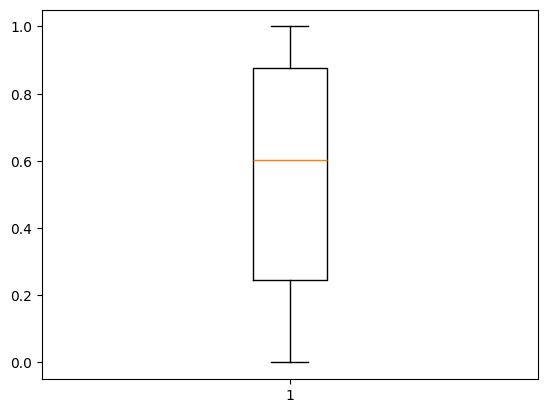

In [115]:
print(np.quantile(hist, 0.25))
print(np.quantile(hist, 0.75))
plt.boxplot(hist)
plt.show

(array([1.06508876, 0.73594675, 0.69156805, 0.85798817, 1.64940828]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

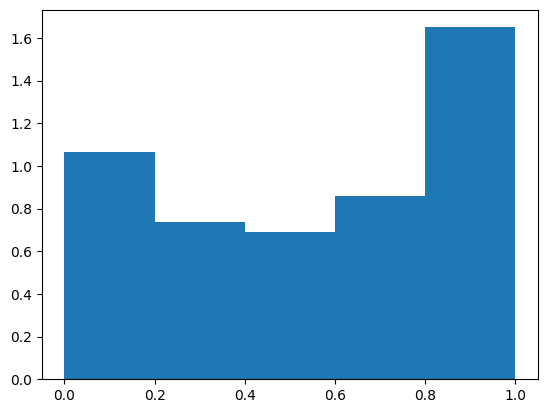

In [116]:
plt.hist(hist, density=True, bins = 5)

61.86224489795919


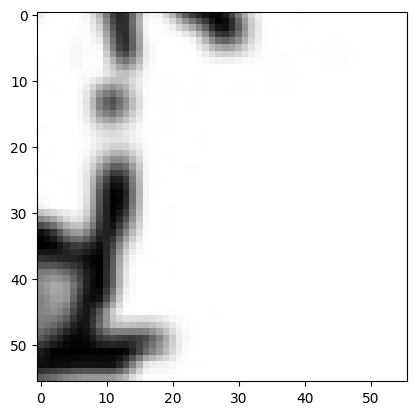

In [61]:
n += 1
print(100*(np.sum(data["all_tiles"][ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][ind][n])

In [4]:
lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.75)[0]
print(lw_ind.shape)

(1884,)


In [5]:
n=0

1
74.39413265306123


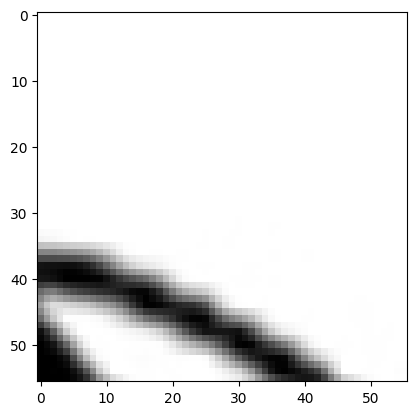

In [6]:
n += 1
print(n)
print(100*(np.sum(data["all_tiles"][lw_ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][lw_ind][n])

In [148]:
data["tile_images"].shape

(3232, 56, 56, 3)

In [110]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([ 240, 1824,  152,   93,   80,   60,  231,  115,  163,   66,   93,
        115])

In [109]:
unique, counts = np.unique(data["tile_cluster"][lw_ind], return_counts=True)
counts

array([220, 532, 152,  93,  80,  60, 214, 113, 146,  66,  93, 115])

In [156]:
A, T, _, _, _ = data["tiles"].shape
img_ind = [[x for _ in range(T)] for x in range(A)]

In [159]:
img_ind = torch.Tensor(np.array(img_ind)).flatten()

In [166]:
img_ind[lw_ind].shape

torch.Size([1884])

# LW Ind Implemented

In [5]:
lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.75)[0]
print(lw_ind.shape)

(1884,)


In [6]:
data["all_tiles"] = data["all_tiles"][lw_ind]
data["all_tiles"].shape

(1884, 56, 56, 3)

# Model Code

In [7]:
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsTransformer
import copy

def split_grid(im, n=4):
  B,C,H,W = im.shape
  ln = int(H/n)
  image = cv2.resize(image,(ln*n, ln*n))
  H = ln
  W = ln
  tiles = [im[x:x+H,y:y+W] for x in range(0,im.shape[0],H) for y in range(0,im.shape[1],W)]

  return torch.Tensor(tiles)


def coo_one_2_two(edge_map):
  edge_map_aux = [[],[]]
  for x in edge_map:
      edge_map_aux[0].append(x[0])
      edge_map_aux[1].append(x[1])

  edge_map_aux = np.array(edge_map_aux)
  return(torch.Tensor(edge_map_aux))



def adjacency_to_coo(adj_matrix):
  rows, cols = np.where(adj_matrix != 0)
  non_diagonal_mask = rows != cols

  filtered_rows = rows[non_diagonal_mask]
  filtered_cols = cols[non_diagonal_mask]

  coo_list = np.stack([filtered_rows, filtered_cols], axis=1)
  return coo_one_2_two(coo_list)



def get_neighbor_coo(data, neighbors = 12, method = "KNN"):
  B,C,H,W = data.shape
  x = data.detach().cpu()
  if method == "KNN":
    transformer = KNeighborsTransformer(n_neighbors=neighbors, mode='connectivity')
    graph = transformer.fit_transform(x.reshape(B,-1)).toarray()
  del x
  return adjacency_to_coo(graph)


def get_past_threshold(data, n_slices = 16, threshold = 0.1):
  distances = []
  avg = torch.mean(data[:n_slices])
  for img in data[n_slices:]:
    distances.append(torch.dist(avg, img))

  distances = torch.Tensor(distances)
  distances = distances/distances.max()
  indices = torch.where(distances < threshold)[0]

  return torch.cat([data[:n_slices], data[n_slices:][indices]], dim = 0), indices

def get_multi_shot_set(data, n_slices = 16, n_shots = 5):
  distances = []
  shot_set = []
  shot_indeces = []
  avg = torch.mean(data[:n_slices])
  for img in data[n_slices:]:
    distances.append(torch.dist(avg, img))

  distances = torch.Tensor(distances)
  values, indices = torch.topk(distances, n_slices*n_shots, largest=False, sorted=True)
  full_set = data[n_slices:][indices]
  
  full_set = torch.cat([data[:n_slices], full_set], dim=0)

  for i in range(n_shots):
    shot_set.append(full_set[i*n_slices: (i+1)*n_slices].to("cpu"))
    shot_indeces.append(indices[i*n_slices: (i+1)*n_slices].to("cpu"))



  return full_set#, torch.Tensor(np.array(shot_set)), indices.to(torch.int), torch.Tensor(np.array(shot_indeces)).to(torch.int)

In [8]:
def tile_split(image, n=2):
    ln = int(224/n)
    image = cv2.resize(image,(ln*n, ln*n))
    
    H = ln
    W = ln
    im2 = copy.deepcopy(image)
    tiles = [im2[x:x+H,y:y+W] for x in range(0,im2.shape[0],H) for y in range(0,im2.shape[1],W)]
    
    return np.array(tiles)

In [9]:
class Stem(nn.Module):
    def __init__(self, in_dim=3, out_dim=48, act='relu'):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//4, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//4),
            act_layer(act),
            nn.Conv2d(out_dim//4, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


In [27]:
class Decode(nn.Module):
    def __init__(self, in_dim=3, out_dim=240, act='relu'):
        super().__init__()
        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(out_dim, out_dim//2, 2, stride=2),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.ConvTranspose2d(out_dim//2, out_dim//4, 2, stride=2),
            nn.BatchNorm2d(out_dim//4),
            act_layer(act),
            nn.ConvTranspose2d(out_dim//4, out_dim//8, 2, stride=2),
            nn.BatchNorm2d(out_dim//8),
            act_layer(act),
            nn.ConvTranspose2d(out_dim//8, out_dim//16, 2, stride=2),
            nn.BatchNorm2d(out_dim//16),
            act_layer(act),
            nn.ConvTranspose2d(out_dim//16, out_dim//16, 2, stride=2),
            nn.BatchNorm2d(out_dim//16),
            act_layer(act),
            nn.ConvTranspose2d(out_dim//16, in_dim, 1, stride=1),
            nn.Conv2d(in_dim, in_dim, 1, 1),
        )

    def forward(self, x):
        x = self.deconvs(x)
        x = (x - torch.min(x))/(torch.max(x) - torch.min(x))
        return x

In [11]:
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer

class FFN(nn.Module):
    def __init__(self, in_features, act='relu', drop_path=0.0):
        super().__init__()
        out_features = in_features
        hidden_features = in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x



In [29]:
class Grapher(nn.Module):
    def __init__(self, in_channels, img_dim, at_heads = 4, act='relu', drop_path=0.0, device = "cuda:7"):
      super(Grapher, self).__init__()
      self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
      )
      self.graph_conv = gnn.GATv2Conv(in_channels*img_dim*img_dim, in_channels*img_dim*img_dim, heads = at_heads)
      self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
      self.fc2 = nn.Sequential(
          nn.Conv2d(in_channels * at_heads, in_channels, 1, stride=1, padding=0),
          nn.BatchNorm2d(in_channels),
      )
      self.device = device

    def forward(self, x, NUM_NEIGHBORS, EDGE_METHOD):
      _tmp = x
      B,C,H,W = x.shape
      x = self.fc1(x)
      edge_index = get_neighbor_coo(x, NUM_NEIGHBORS, method = EDGE_METHOD)
      edge_index = torch.Tensor(edge_index).to(torch.int32).to(self.device)
      x = x.reshape(B,-1)
      x = self.graph_conv(x, edge_index)
      del edge_index
      x = x.reshape(B,-1,H,W)
      x = self.fc2(x)
      x = self.drop_path(x) + _tmp
      return x

In [30]:
class GraphEncoderBlock(nn.Module):
    def __init__(self, in_channels = 3, img_dim = 56, at_heads = 4, act='relu', drop_path=0.0, device = "cuda:7"):
      super(GraphEncoderBlock, self).__init__()
      self.grapher = Grapher(in_channels, img_dim, at_heads, act, drop_path, device)
      self.ffn = FFN(in_channels, act, drop_path)


    def forward(self, x, NUM_NEIGHBORS, EDGE_METHOD):
      x = self.grapher(x, NUM_NEIGHBORS, EDGE_METHOD)
      return self.ffn(x)


In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim, act='relu'):
      super().__init__()
      self.convs = nn.Sequential(
          nn.Conv2d(in_dim, out_dim//16, 3, stride=2, padding=1),
          nn.BatchNorm2d(out_dim//16),
          act_layer(act),
          nn.Conv2d(out_dim//16, out_dim//8, 3, stride=2, padding=1),
          nn.BatchNorm2d(out_dim//8),
          act_layer(act),
          nn.Conv2d(out_dim//8, out_dim//4, 3, stride=2, padding=1),
          nn.BatchNorm2d(out_dim//4),
          act_layer(act),
          nn.Conv2d(out_dim//4, out_dim//2, 3, stride=2, padding=1),
          nn.BatchNorm2d(out_dim//2),
          act_layer(act),
          nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
          nn.BatchNorm2d(out_dim),
          act_layer(act),
          nn.Flatten(),
          nn.Linear(out_dim*7*7, 4096),
          act_layer(act),
          nn.Linear(4096, 1),
      )

    def forward(self, x):
      x = self.convs(x)
      x = x.reshape(x.shape[0])
      return x

In [15]:
class SigmoidPredictor(nn.Module):
    def __init__(self, in_channels, img_dim, at_heads = 4, act='relu', drop_path=0.0, device = "cuda:2"):
      super(SigmoidPredictor, self).__init__()
      self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
      )
      self.graph_conv = gnn.GATv2Conv(in_channels*img_dim*img_dim, in_channels*img_dim*img_dim, heads = at_heads)
      self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
      self.act = act_layer(act)
      self.fc2 = nn.Sequential(
          nn.Conv2d(in_channels * at_heads, in_channels, 1, stride=1, padding=0),
          nn.BatchNorm2d(in_channels),
          self.act,
          nn.Flatten(),
          nn.Linear(img_dim*img_dim*in_channels, 4096),
          self.act,
          nn.Linear(4096, 4096),
          self.act,
          nn.Linear(4096, 1),
      )
      self.device = device

    def forward(self, x, NUM_NEIGHBORS, EDGE_METHOD):
      B,C,H,W = x.shape
      x = self.fc1(x)
      edge_index = get_neighbor_coo(x, NUM_NEIGHBORS, method = EDGE_METHOD)
      edge_index = torch.Tensor(edge_index).to(torch.int32).to(self.device)
      x = x.reshape(B,-1)
      x = self.graph_conv(x, edge_index)
      del edge_index
      x = x.reshape(B,-1,H,W)
      x = self.fc2(x)
      return x

In [16]:
class PatchPredictor(nn.Module):
    def __init__(self, graph_size = 600, num_of_heads = 2,  in_channels = 3, out_channels = 128, img_dim = 56, at_heads = 4, act='relu', drop_path=0.05, device="cuda:2"):
      super(PatchPredictor, self).__init__()
      self.encoder_blocks = [GraphEncoderBlock(out_channels, img_dim, at_heads, act, drop_path, device).to(device) for i in range(num_of_heads)]
      self.stem = Stem(in_channels, out_channels).to(device)
      self.act = act_layer(act)
      self.graph_size = graph_size
      
      self.out = SigmoidPredictor(out_channels, img_dim, at_heads, act, drop_path, device).to(device)

    def forward(self, x, T, NUM_NEIGHBORS, EDGE_METHOD):
      x = self.stem(x)
      for block in self.encoder_blocks:
        x = block(x, NUM_NEIGHBORS, EDGE_METHOD)
      return self.out(x, NUM_NEIGHBORS, EDGE_METHOD).reshape(self.graph_size)
        

In [75]:
class FullModel(nn.Module):
    def __init__(self, num_slices = 16, num_shots = 3, num_of_heads = 2, num_blocks_per_head = 2, in_channels = 3, out_channels = 48, img_dim = 56, at_heads = 4, act='relu', drop_path=0.0, device="cuda:7", deletion_threshold = 0.5):
      super(FullModel, self).__init__()
      self.encoder_blocks = GraphEncoderBlock(out_channels, img_dim, at_heads, act, drop_path, device).to(device)
      self.encoder_block2 = GraphEncoderBlock(out_channels, img_dim, at_heads, act, drop_path, device).to(device)
      #self.gen_encode = Encode(in_channels, out_channels, act)
      self.gen_decode = Decode(in_channels, (out_channels*(num_shots+1)*num_slices), act)
      #self.gen_decode = Big_Decoder((out_channels*num_shots*num_slices), in_channels)
      self.stem = Stem(in_channels, out_channels)
      self.deletion_threshold = deletion_threshold
      self.num_shots = num_shots
      self.img_dim = img_dim
      self.device = device

    def forward(self, query_image, x, T, NUM_NEIGHBORS, EDGE_METHOD):
      x = self.stem(x)
      indeces = torch.Tensor([i for i in range(x.shape[0]-16)])
      x = self.encoder_blocks(x, NUM_NEIGHBORS, EDGE_METHOD)
      x = self.encoder_block2(x, NUM_NEIGHBORS, EDGE_METHOD)

        #with torch.no_grad():
          #x, t_indeces = get_past_threshold(x, T, self.deletion_threshold)
          #indeces = indeces[t_indeces]

      n_shot_indices = []
      with torch.no_grad():
        full_set = get_multi_shot_set(x, T, self.num_shots)
        #print(full_set.shape)
        #for shot in shot_indices:
          #n_shot_indices.append(indeces[shot])
        #n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)
        #indeces = indeces[remaining_indeces]
        full_set = full_set.reshape(-1, self.img_dim, self.img_dim)

      return self.gen_decode(full_set.unsqueeze(0))

# Model Training

In [67]:
NUM_SAMPLES_PER_GRAPH = 100
NUM_LINES = 4
NUM_NEIGHBORS = 5
NUM_BLOCK_LOOPS = 2
NUM_BLOCKS_PER_HEAD = 2
EDGE_METHOD = "KNN"
DELETION_THRESHOLD = 0.5
GET_BASE_TILES = True
N_SHOTS = 2
DEVICE = "cuda:7" if torch.cuda.is_available() else "cpu"
ATTENTION_HEADS = 4
ACTIVATION_TYPE = "relu"

EPOCHS = 100
LR = 0.0001
GRAPH_BATCH_SIZE = 80
EPOCH_BATCH_SIZE = 100
TRAIN_BATCH_SIZE = 20
REAL_LABEL = 1
FAKE_LABEL = 0
SWITCH_THRESHOLD = -1

NUM_GRAPH_NODES = 600

In [59]:
DEVICE

'cuda:7'

In [51]:
train_images = torch.Tensor(data['image']).to(DEVICE).to(torch.float32)
train_images = (train_images - torch.min(train_images))/(torch.max(train_images) - torch.min(train_images)).to(DEVICE)

train_tiles = torch.Tensor(data['all_tiles']).to(DEVICE).to(torch.float32)
train_tiles = (train_tiles - torch.min(train_tiles))/(torch.max(train_tiles) - torch.min(train_tiles)).to(DEVICE)

all_query_tiles = torch.Tensor(data['tiles']).to(DEVICE).to(torch.float32)
all_query_tiles = (all_query_tiles - torch.min(all_query_tiles))/(torch.max(all_query_tiles) - torch.min(all_query_tiles)).to(DEVICE)

train_index = np.array([x for x in range(train_images.shape[0])])

In [25]:
del train_images, train_tiles, all_query_tiles, train_index

In [39]:
model = PatchPredictor(NUM_GRAPH_NODES, NUM_BLOCKS_PER_HEAD, 3, 128, 7, ATTENTION_HEADS, ACTIVATION_TYPE, device = DEVICE).to(DEVICE)

In [40]:
B,T,H,W,C = all_query_tiles.shape
 
out = model(train_tiles[:NUM_GRAPH_NODES].reshape(-1, 3, 56, 56), T, NUM_NEIGHBORS, EDGE_METHOD)

In [41]:
out.shape

torch.Size([600])

In [27]:
del model

# Gen Model Training Loop (Failed for now)

In [60]:
del model

In [76]:
model = FullModel(16 ,N_SHOTS, NUM_BLOCK_LOOPS, NUM_BLOCKS_PER_HEAD, 3, 48, 7, 4)
model = model.to(DEVICE)

In [77]:
d_model = Discriminator(3, 512)
d_model = d_model.to(DEVICE)

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr = LR)
loss_func = nn.BCEWithLogitsLoss()
mse_loss_func = nn.MSELoss()

In [79]:
for epoch in range(EPOCHS):
  print(epoch)
  B,T,H,W,C = all_query_tiles.shape
  model.train()
  running_loss = 0.0
  count = 0
  #graph_indeces = np.random.choice(np.array([x for x in range(B)]),
  #                                 size=GRAPH_BATCH_SIZE, replace=False)

  train_indeces = np.random.choice(np.array([x for x in range(B)]),
                                   size=EPOCH_BATCH_SIZE, replace=False)
  train_indeces = train_indeces.reshape(-1, TRAIN_BATCH_SIZE)


  graph_sample = train_tiles.reshape(-1, 3, 56, 56)
  graph_sample = graph_sample.unsqueeze(0).expand(TRAIN_BATCH_SIZE, -1, 3, 56, 56)
  #B,_,H,W,C = graph_sample.shape
  #graph_sample = graph_sample.reshape(B*T,C,H,W)

  for i in train_indeces:
    #query_tiles = all_query_tiles[i].reshape(TRAIN_BATCH_SIZE, T,C,H,W)
    query_img = train_images[i].reshape(TRAIN_BATCH_SIZE, 3,224,224)

    input = graph_sample #torch.cat([query_tiles, graph_sample], dim=1)

    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
    query_img = query_img.to(DEVICE)
    input = input.to(DEVICE)

    if epoch>SWITCH_THRESHOLD:
      d_optimizer.zero_grad()

      label = torch.full((TRAIN_BATCH_SIZE,), REAL_LABEL, dtype=torch.float, device=DEVICE)
      d_real_pred = d_model(query_img).view(-1)
      d_real_loss = loss_func(d_real_pred, label)
      drl = d_real_loss.mean().item()

    pred = []

    for j in tqdm(input):
      aux = model(query_img, j, T, NUM_NEIGHBORS, EDGE_METHOD)
      pred.append(aux)
      del aux

    pred = torch.cat(pred, dim=0)

    if epoch > SWITCH_THRESHOLD:

      label_fake = torch.full((TRAIN_BATCH_SIZE,), FAKE_LABEL, dtype=torch.float, device=DEVICE)
      d_fake_pred = d_model(pred.detach()).view(-1)
      d_fake_loss = loss_func(d_fake_pred,label_fake)
      dfl = d_fake_loss.mean().item()

      d_loss = (d_real_loss + d_fake_loss)/2
      d_loss.backward()
      d_optimizer.step()

      optimizer.zero_grad()
      d_g_pred = d_model(pred).view(-1)
      d_g_loss = loss_func(d_g_pred, label)
      dgl = d_g_loss.mean().item()

    #g_mse_loss = mse_loss_func(pred, query_img)
    #gml = g_mse_loss.mean().item()

    if epoch > SWITCH_THRESHOLD:

      #g_loss = d_g_loss# + g_mse_loss*0.75
      #g_loss.backward()
      d_g_loss.backward()
      optimizer.step()
      print("Discrimor:", dfl+drl)
      print("Generator:", dgl)
      #print("Generator MSE:", gml)

    else:
      #g_mse_loss.backward()
      optimizer.step()
      #print("Generator:", gml)

0


 50%|█████     | 10/20 [00:18<00:18,  1.84s/it]


KeyboardInterrupt: 

In [ ]:
pred.dtype

torch.float32

In [71]:
i = 25
B,T,H,W,C = all_query_tiles.shape
query_tiles = all_query_tiles[i].reshape(T,C,H,W)
query_img = train_images[i].reshape(1,3,224,224)
mask = torch.arange(train_images.shape[0]) != i
graph_sample = train_tiles.reshape(-1, 3, 56, 56)
input = torch.cat([query_tiles, graph_sample], dim=0)

indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
query_img = query_img.to(DEVICE)
input = input.to(DEVICE)

In [72]:
print(query_img.shape)
print(input.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1900, 3, 56, 56])


In [73]:
with torch.no_grad():
  out = model(query_img, input, T, NUM_NEIGHBORS, EDGE_METHOD)

In [35]:
out.shape

torch.Size([1, 3, 224, 224])

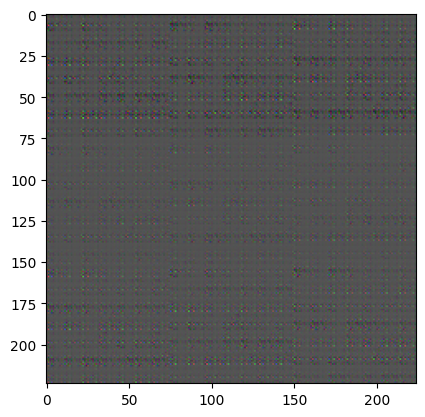

In [74]:
plt.imshow(out.reshape(224,224,3).detach().cpu().numpy())
plt.show()

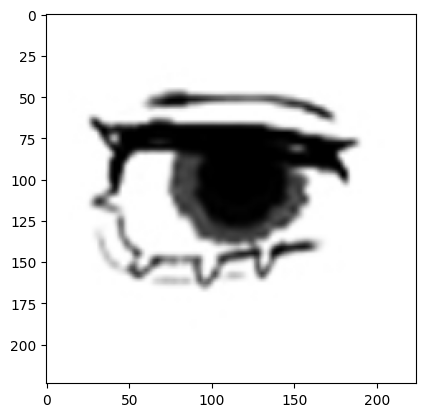

In [37]:
plt.imshow(query_img.reshape(224,224,3).detach().cpu().numpy())
plt.show()

In [ ]:
for i in range(train_images.shape[0]):
  with torch.no_grad():
    B,T,H,W,C = train_tiles.shape
    query_img = train_tiles[i].reshape(T,C,H,W)
    mask = torch.arange(train_images.shape[0]) != i
    graph_sample = train_tiles[np.random.choice(train_index[mask], NUM_SAMPLES_PER_GRAPH, replace=False)]
    B,_,H,W,C = graph_sample.shape
    graph_sample = graph_sample.reshape(B*T,C,H,W)
    input = torch.cat([query_img, graph_sample], dim=0)
    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])

  #Insert Stem Model to get embeddings

  for loop in range(NUM_BLOCK_LOOPS):
    input = model(input, T, NUM_NEIGHBORS, EDGE_METHOD)

    with torch.no_grad():
      input, t_indeces = get_past_threshold(input, T, DELETION_THRESHOLD)
      indeces = indeces[t_indeces]

  n_shot_indices = []
  with torch.no_grad():
    full_set, shot_set, remaining_indeces, shot_indices = get_multi_shot_set(input, T, N_SHOTS)
    for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
    n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)
    indeces = indeces[remaining_indeces]


  #Insert Generative Model


  break


NameError: name 'train_images' is not defined

In [ ]:
full_set, shot_set, remaining_indeces, shot_indices  = get_multi_shot_set(input, T, N_SHOTS)

In [ ]:
train_images.shape

torch.Size([202, 224, 224, 3])

In [ ]:
train_tiles.shape

torch.Size([202, 16, 56, 56, 3])

In [ ]:
n_shot_indices=[]
with torch.no_grad():
  for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
  n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)

In [ ]:
n_shot_indices

tensor([[ 824,   57, 1240,   56,  974,  817, 1355, 1576,  939,  318,  315,  443,
          843, 1244,  392, 1232],
        [ 491,  859,  971,   59, 1044,  507,  855, 1400,   50, 1051,  171, 1554,
          849,   34,  850, 1352],
        [ 168, 1571, 1057,  333, 1003,  321,  203, 1099, 1453,  573,  238,  999,
          877, 1262,   92,  322]], dtype=torch.int32)

In [ ]:
shot_indices

tensor([[425,  33, 660,  32, 516, 422, 716, 831, 494, 156, 153, 219, 436, 661,
         192, 657],
        [241, 447, 514,  34, 552, 250, 446, 738,  30, 555,  88, 817, 442,  19,
         443, 715],
        [ 87, 829, 561, 164, 534, 159, 104, 580, 767, 295, 123, 532, 457, 668,
          51, 160]], dtype=torch.int32)

In [ ]:
full_set.shape

torch.Size([48, 3, 56, 56])

In [ ]:
shot_set.shape

torch.Size([3, 16, 3, 56, 56])

In [ ]:
indeces

tensor([ 824.,   57., 1240.,   56.,  974.,  817., 1355., 1576.,  939.,  318.,
         315.,  443.,  843., 1244.,  392., 1232.,  491.,  859.,  971.,   59.,
        1044.,  507.,  855., 1400.,   50., 1051.,  171., 1554.,  849.,   34.,
         850., 1352.,  168., 1571., 1057.,  333., 1003.,  321.,  203., 1099.,
        1453.,  573.,  238.,  999.,  877., 1262.,   92.,  322.])

In [ ]:
grapher_model = Grapher(3, 4).to("cuda")

In [ ]:
out = grapher_model(input, NUM_NEIGHBORS, EDGE_METHOD)

In [ ]:
out.shape

torch.Size([1616, 3, 56, 56])

In [ ]:
indeces.shape

torch.Size([48])

In [ ]:
indeces

tensor([ 664.,  824., 1353., 1352.,  222., 1154.,  600., 1108.,  657., 1035.,
          94., 1033., 1112., 1512.,   91., 1038.,  606., 1026.,  797.,  382.,
         828.,  136., 1143.,  816., 1160.,  923.,  311.,  962., 1355., 1239.,
        1432.,  925.,  219.,  439.,  187.,  779., 1435., 1155.,  926., 1105.,
        1106., 1234., 1346., 1192., 1507., 1304.,  673., 1371.])

In [ ]:
t_indeces.shape

torch.Size([807])

In [ ]:
graph_sample[indeces.to(torch.int)].shape

torch.Size([48, 3, 56, 56])

In [ ]:
input.shape

torch.Size([1325, 3, 56, 56])

In [ ]:
shot_set.shape

torch.Size([4, 16, 3, 56, 56])

In [ ]:
full_set.shape

torch.Size([48, 3, 56, 56])

In [ ]:
T

16

In [ ]:
edge_index.shape

torch.Size([2, 17920])

In [ ]:
graph_sample.shape

torch.Size([1600, 3, 56, 56])

In [ ]:
query_img.shape

torch.Size([16, 3, 56, 56])

In [ ]:
input.shape

torch.Size([1616, 3, 56, 56])